In [35]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from scipy.special import expit

from aml_utils import test_case_checker, perform_computation, show_test_cases

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0. Data 

Since the MNIST data (http://yann.lecun.com/exdb/mnist/) is stored in a binary format, we would rather have an API handle the loading for us. 

Pytorch (https://pytorch.org/) is an Automatic Differentiation library that we may see and use later in the course. 

Torchvision (https://pytorch.org/docs/stable/torchvision/index.html?highlight=torchvision#module-torchvision) is an extension library for pytorch that can load many of the famous data sets painlessly. 

We already used Torchvision for downloading the MNIST data. It is stored in a numpy array file that we will load easily.

## 0.1 Loading the Data

In [2]:
if os.path.exists('../MeanField-lib/mnist.npz'):
    npzfile = np.load('../MeanField-lib/mnist.npz')
    train_images_raw = npzfile['train_images_raw']
    train_labels = npzfile['train_labels']
    eval_images_raw = npzfile['eval_images_raw']
    eval_labels = npzfile['eval_labels']
else:
    import torchvision
    download_ = not os.path.exists('../MeanField-lib/mnist')
    data_train = torchvision.datasets.MNIST('../MeanField-lib/mnist', train=True, transform=None, target_transform=None, download=download_)
    data_eval = torchvision.datasets.MNIST('../MeanField-lib/mnist', train=False, transform=None, target_transform=None, download=download_)

    train_images_raw = data_train.data.numpy()
    train_labels = data_train.targets.numpy()
    eval_images_raw = data_eval.data.numpy()
    eval_labels = data_eval.targets.numpy()

    np.savez('../MeanField-lib/mnist.npz', train_images_raw=train_images_raw, train_labels=train_labels, 
             eval_images_raw=eval_images_raw, eval_labels=eval_labels) 

In [3]:
noise_flip_prob = 0.04

# <span style="color:blue">Task 1</span>

Write the function `get_thresholded_and_noised` that does image thresholding and flipping pixels. More specifically, this functions should exactly apply the following two steps in order:

1. **Thresholding**: First, given the input threshold argument, you must compute a thresholded image array. This array should indicate whether each element of `images_raw` is **greater than or equal to**  the `threshold` argument. We will call the result of this step the thresholded image.
2. **Noise Application (i.e., Flipping Pixels)**: After the image was thresholded, you should use the `flip_flags` input argument and flip the pixels with a corresponding `True` entry in `flip_flags`. 

  * `flip_flags` mostly consists of `False` entries, which means you should not change their corresponding pixels. Instead, whenever a pixel had a `True` entry in `flip_flags`, that pixel in the thresholded image must get flipped. This way you will obtain the noised image.
3. **Mapping Pixels to -1/+1**: You need to make sure the output image pixels are mapped to -1 and 1 values (as opposed to 0/1 or True/False).

`get_thresholded_and_noised` should take the following arguments:

1. `images_raw`: A numpy array. Do not assume anything about its shape, dtype or range of values. Your function should be careless about these attributes.
2. `threshold`: A scalar value.
3. `flip_flags`: A numpy array with the same shape as `images_raw` and `np.bool` dtype. This array indicates whether each pixel should be flipped or not.

and return the following:

* `mapped_noised_image`: A numpy array with the same shape as `images_raw`.  This array's entries should either be -1 or 1.

In [26]:
def get_thresholded_and_noised(images_raw, threshold, flip_flags):
    
    # your code here
    thresholded_image = images_raw.astype(np.int32)
    thresholded_image[images_raw >= threshold] = 1
    thresholded_image[images_raw < threshold] = -1
    
    thresholded_image[flip_flags == True] *= -1
    mapped_noised_image = thresholded_image
    
    assert (np.abs(mapped_noised_image)==1).all()
    return mapped_noised_image.astype(np.int32)

In [27]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


The reference and solution images are the same to a T! Well done on this test case.


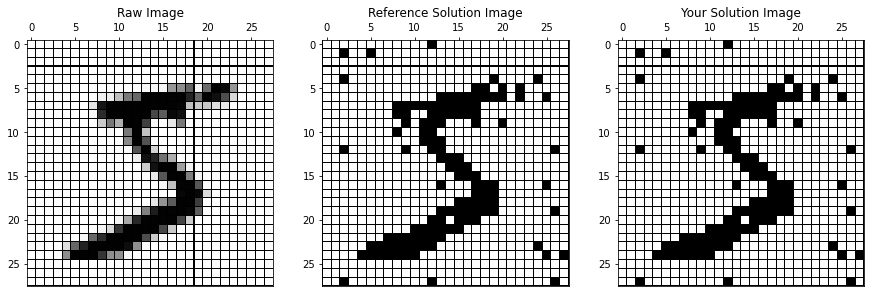

    Enter nothing to go to the next image
or
    Enter "s" when you are done to recieve the three images. 
        **Don't forget to do this before continuing to the next step.**
s


In [28]:
# Performing sanity checks on your implementation
def test_thresh_noise(x, seed = 12345, p = noise_flip_prob, threshold = 128):        
    np_random = np.random.RandomState(seed=seed)
    flip_flags = (np_random.uniform(0., 1., size=x.shape) < p)
    return get_thresholded_and_noised(x, threshold, flip_flags)

(orig_image, ref_image, test_im, success_thr) = show_test_cases(test_thresh_noise, task_id='1_V')

assert success_thr

# Checking against the pre-computed test database
test_results = test_case_checker(get_thresholded_and_noised, task_id=1)
assert test_results['passed'], test_results['message']

In [29]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


## 0.2 Applying Thresholding and Noise to Data

In [30]:
if perform_computation:
    X_true_grayscale = train_images_raw[:10, :, :]

    np_random = np.random.RandomState(seed=12345)
    flip_flags = flip_flags = (np_random.uniform(0., 1., size=X_true_grayscale.shape) < noise_flip_prob)
    initial_pi = np_random.uniform(0, 1, size=X_true_grayscale.shape) # Initial Random Pi values

    X_true = get_thresholded_and_noised(X_true_grayscale, threshold=128, flip_flags=flip_flags * 0)
    X_noised = get_thresholded_and_noised(X_true_grayscale, threshold=128, flip_flags=flip_flags)

# <span style="color:blue">Task 2</span>

Write a funciton named `sigmoid_2x` that given a variable $X$ computes the following:

$$f(X) := \frac{\exp(X)}{\exp(X) + \exp(-X)}$$

The input argument is a numpy array $X$, which could have any shape. Your output array must have the same shape as $X$.

**Important Note**: Theoretically, $f$ satisfies the following equations:

$$\lim_{X\rightarrow +\infty} f(X) = 1$$
$$\lim_{X\rightarrow -\infty} f(X) = 0$$

Your implementation must also work correctly even on these extreme edge cases. In other words, you must satisfy the following tests.
* `sigmoid_2x(np.inf)==1` 
* `sigmoid_2x(-np.inf)==0`.

**Hint**: You may find `scipy.special.expit` useful.

In [40]:
def sigmoid_2x(X):
    
    # your code here
    output = expit(2*X)
    
    return output

In [41]:
# Performing sanity checks on your implementation
assert sigmoid_2x(+np.inf) == 1.
assert sigmoid_2x(-np.inf) == 0.
assert np.array_equal(sigmoid_2x(np.array([0, 1])).round(3), np.array([0.5, 0.881]))

# Checking against the pre-computed test database
test_results = test_case_checker(sigmoid_2x, task_id=2)
assert test_results['passed'], test_results['message']

In [42]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


# 1. Applying Mean-field Approximation to Boltzman Machine's Variational Inference Problem

# <span style="color:blue">Task 3</span>

Write a `boltzman_meanfield` function that applies the mean-field approximation to the Boltzman machine. 

Recalling the textbook notation, $X_i$ is the observed value of pixel $i$, and $H_i$ is the true value of pixel $i$ (before applying noise). For instance, if we have a $3 \times 3$ image, the corresponding Boltzman machine looks like this: 

```
       X_1        X_2        X_3
      /          /          /
     H_1 ------ H_2 ------ H_3
      |          |          |
      |          |          |
      |          |          |
      | X_4      | X_5      | X_6
      |/         |/         |/ 
     H_4 ------ H_5 ------ H_6
      |          |          |
      |          |          |
      |          |          |
      | X_7      | X_8      | X_9
      |/         |/         |/ 
     H_7 ------ H_8 ------ H_9
```     

Here, we a adopt a slightly simplified notation from the textbook and define $\mathcal{N}(i)$ to be the neighbors of pixel $i$ (the pixels adjacent to pixel $i$). For instance, in the above figure, we have $\mathcal{N}(1) = \{2,4\}$, $\mathcal{N}(2) = \{1,3,5\}$, and $\mathcal{N}(5) = \{2,4,6,8\}$.


With this, the process in the textbook can be summarized as follows:

```
1. for iteration = 1, 2, 3, ....,
  2. Pick a random pixel i.
  3. Find pixel i's new parameter as
```
$$\pi_i^{\text{new}} = \frac{\exp(\theta_{ii}^{(2)} X_i + \sum_{j\in \mathcal{N}(i)} \theta_{ij}^{(1)} (2\pi_j -1))}{\exp(\theta_{ii}^{(2)} X_i + \sum_{j\in \mathcal{N}(i)} \theta_{ij}^{(1)} (2\pi_j -1)) + \exp(-\theta_{ii}^{(2)} X_i - \sum_{j\in \mathcal{N}(i)} \theta_{ij}^{(1)} (2\pi_j -1))} .$$
```
  4. Replace the existing parameter for pixel i with the new one.
```
$$\pi_i \leftarrow \pi_i^{\text{new}}$$

Since our computational resources are extremely vectorized, we will make the following minor algorithmic modification and ask you to implement the following instead:

```
1. for iteration = 1, 2, 3, ....,
  2. for each pixels i:
  3. Find pixel i's new parameter, but do not update the original parameter yet.
```
$$\pi_i^{\text{new}} = \frac{\exp(\theta_{ii}^{(2)} X_i + \sum_{j\in \mathcal{N}(i)} \theta_{ij}^{(1)} (2\pi_j -1))}{\exp(\theta_{ii}^{(2)} X_i + \sum_{j\in \mathcal{N}(i)} \theta_{ij}^{(1)} (2\pi_j -1)) + \exp(-\theta_{ii}^{(2)} X_i - \sum_{j\in \mathcal{N}(i)} \theta_{ij}^{(1)} (2\pi_j -1))} .$$
```
  4. Once you have computed all the new parameters, update all of them at the same time:
```
$$\pi \leftarrow \pi^{\text{new}}$$

We assume that the parameters $\theta_{ii}^{(2)}$ have the same value for all $i$ and denote their common value by scalar `theta_X`. Moreover, we assume that the parameters $\theta_{ij}^{(1)}$ have the same value for all $i,j$ and denote their common value by scalar `theta_pi`.

The `boltzman_meanfield` function must take the following input arguments:
1. `images`: A numpy array with the shape `(N,height,width)`, where 
    * `N` is the number of samples and could be anything,
    * `height` is each individual image's height in pixels (i.e., number of rows in each image),
    * and `width` is each individual image's width in pixels (i.e., number of columns in each image).
      * Do not assume anything about `images`'s dtype or the number of samples or the `height` or the `width`.
      * The entries of `images` are either -1 or 1.
2. `initial_pi`: A numpy array with the same shape as `images` (i.e. `(N,height,width)`). This variable is corresponding to the initial value of $\pi$ in the textbook analysis and above equations. Note that for each of the $N$ images, we have a different $\pi$ variable.

3. `theta_X`: A scalar with a default value of `0.5*np.log(1/noise_flip_prob-1)`. This variable represents $\theta_{ii}^{(2)}$ in the above update equation.

4. `theta_pi`: A scalar with a default value of 2. This variable represents $\theta_{ij}^{(1)}$ in the above update equation.

5. `iterations`: A scalar with a default value of 100. This variable denotes the number of update iterations to perform.

The `boltzman_meanfield` function must return the final $\pi$ variable as a numpy array called `pi`, and should contain values that are between 0 and 1. 

**Hint**: You may find the `sigmoid_2x` function, that you implemented earlier, useful.

**Hint**: If you want to find the summation of neighboring elements for all of a 2-dimensional matrix, there is an easy and efficient way using matrix operations. You can initialize a zero matrix, and then add four shifted versions (i.e., left-, right-, up-, and down-shifted versions) of the original matrix to it. You will have to be careful in the assignment and selection indices, since you will have to drop one row/column for each shifted version of the matrix.
  * Do **not** use `np.roll` if you're taking this approach.

In [56]:
def boltzman_meanfield(images, initial_pi, theta_X=0.5*np.log(1/noise_flip_prob-1), theta_pi=2, iterations=100):
    if len(images.shape)==2:
        # In case a 2d image was given as input, we'll add a dummy dimension to be consistent
        X = images.reshape(1,*images.shape)
    else:
        # Otherwise, we'll just work with what's given
        X = images
    
    pi = initial_pi
    # your code here
    N, height, width = images.shape
    for _ in range(iterations):
        # Initialize sum with all zeros:
        tempSum = np.zeros(pi.shape)
        # Update pi
        pi =  (2 * pi - 1)
        
        tempSum[:, 1:, :] = tempSum[:, 1:, :] + pi[:, :-1, :]
        tempSum[:, :-1, :] = tempSum[:, :-1, :] + pi[:, 1:, :]
        tempSum[:, :, 1:] = tempSum[:, :, 1:] + pi[:, :, :-1]
        tempSum[:, :, :-1] = tempSum[:, :, :-1] + pi[:, :, 1:]

        pi = sigmoid_2x( theta_pi * tempSum + (theta_X * images) )
        
    return pi.reshape(*images.shape)

In [57]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


The reference and solution images are the same to a T! Well done on this test case.


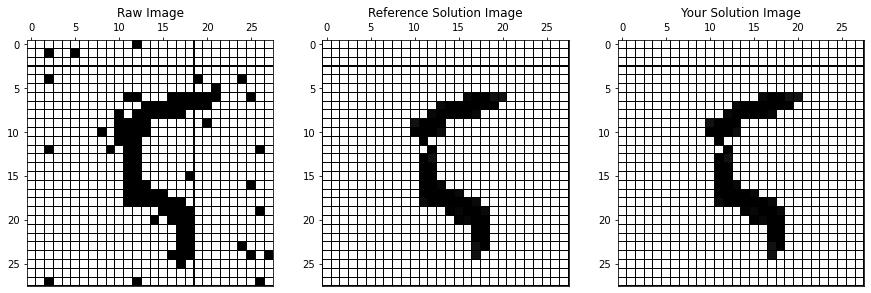

    Enter nothing to go to the next image
or
    Enter "s" when you are done to recieve the three images. 
        **Don't forget to do this before continuing to the next step.**
s


In [58]:
# Performing sanity checks on your implementation
def test_boltzman(x, seed = 12345, theta_X=0.5*np.log(1/noise_flip_prob-1), theta_pi=2, iterations=100):        
    np_random = np.random.RandomState(seed=seed)
    initial_pi = np_random.uniform(0,1, size=x.shape)
    return boltzman_meanfield(x, initial_pi, theta_X=theta_X, 
                              theta_pi=theta_pi, iterations=iterations)
    
(orig_image, ref_image, test_im, success_is_row_inky) = show_test_cases(test_boltzman, task_id='3_V')

assert success_is_row_inky

# Checking against the pre-computed test database
test_results = test_case_checker(boltzman_meanfield, task_id=3)
assert test_results['passed'], test_results['message']

In [59]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


## 2. Tuning the Boltzman Machine's Hyper-Parameters

Now, with the `boltzman_meanfield` function that you implemented above, here see the effect of changing hyper parameters `theta_X` and `theta_pi` which were defined in Task 3. 

- We set `theta_X` to be `0.5*np.log(1/noise_flip_prob-1)` where `noise_flip_prob` was the probability of flipping each pixel. Try to think why this is a reasonable choice. (This is also related to one of the questions in the follow-up quiz).
- We try different values for `theta_pi`. 

For each value of `theta_pi`, we the apply the denoising and compare the denoised images to the original ones. We adopt several statistical measures to compare original and denoised images and to finally decide which value of `theta_pi` is better. Remember that during the noising process, we chose some pixels and decide to flip them, and during the denoising process we essentially try to detect such pixels. Let `P` be the total number of pixels that we flip during the noise adding process, and `N` be the total number of pixels that we do not flip during the noise adding process. We can define:

- True Positive (`TP`). Defined to be the total number of pixels that are flipped during the noise adding process, and we successfully detect them during the denoising process. 
- True Positive Rate (`TPR`). Other names: sensitivity, recall. Defined to be the ratio `TP / P`.
- False Positive (`FP`). Defined to be the number of pixels that were detected as being noisy during the denosing process, but were not really noisy. 
- False Positive Rate (`FPR`). Other name: fall-out. Defined to be the ratio `FP/N`.
- Positive Predictive Value (`PPV`). Other name: precision. Defined to be the ratio `TP / (TP + FP)`.
- `F1` score. Defined to be the harmonic mean of precision (`PPV`) and recall (`TPR`), or equivalently `2 TP / (2 TP + FP + FN)`. 

Since we fix `theta_X` in this section and evaluate different values of `theta_pi`, in the plots, `theta` refers to `theta_pi`.

In [60]:
def get_tpr(preds, true_labels):
    TP = (preds * (preds == true_labels)).sum()
    P = true_labels.sum()
    if P==0:
        TPR = 1.
    else:
        TPR = TP / P
    
    return TPR

def get_fpr(preds, true_labels):
    FP = (preds * (preds != true_labels)).sum()
    N = (1-true_labels).sum()
    if N==0:
        FPR=1
    else:
        FPR = FP / N
    return FPR

def get_ppv(preds, true_labels):
    TP = (preds * (preds == true_labels)).sum()
    FP = (preds * (preds != true_labels)).sum()
    if (TP + FP) == 0:
        PPV = 1
    else:
        PPV = TP / (TP + FP)
    return PPV

def get_f1(preds, true_labels):
    TP = (preds * (preds == true_labels)).sum()
    FP = (preds * (preds != true_labels)).sum()
    FN = ((1-preds) * (preds != true_labels)).sum()
    if (2 * TP + FP + FN) == 0:
        F1 = 1
    else:
        F1 = (2 * TP) / (2 * TP + FP + FN)
    return F1

In [61]:
if perform_computation:
    all_theta = np.arange(0, 10, 0.2).tolist() + np.arange(10, 100, 5).tolist()

    tpr_list, fpr_list, ppv_list, f1_list = [], [], [], []

    for theta in all_theta:
        meanfield_pi = boltzman_meanfield(X_noised, initial_pi, theta_X=0.5*np.log(1/noise_flip_prob-1), theta_pi=theta, iterations=100)
        X_denoised = 2 * (meanfield_pi > 0.5) - 1

        predicted_noise_pixels = (X_denoised != X_noised)
        tpr = get_tpr(predicted_noise_pixels, flip_flags)
        fpr = get_fpr(predicted_noise_pixels, flip_flags)
        ppv = get_ppv(predicted_noise_pixels, flip_flags)
        f1 = get_f1(predicted_noise_pixels, flip_flags)

        tpr_list.append(tpr)
        fpr_list.append(fpr)
        ppv_list.append(ppv)
        f1_list.append(f1)

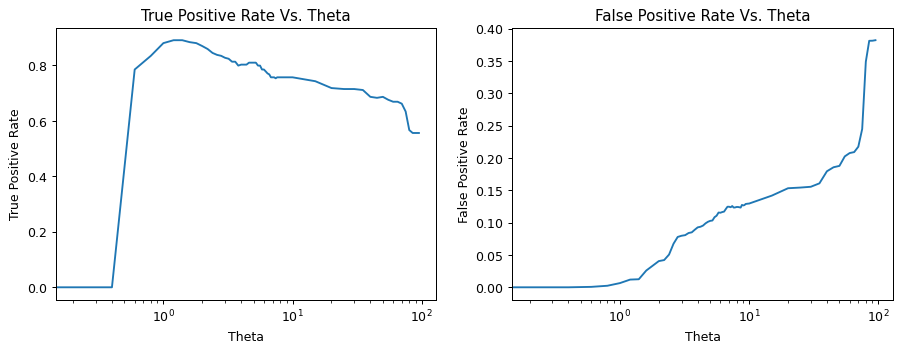

In [62]:
if perform_computation:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4), dpi=90)

    ax=axes[0]
    ax.plot(all_theta, tpr_list)
    ax.set_xlabel('Theta')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('True Positive Rate Vs. Theta')
    ax.set_xscale('log')

    ax=axes[1]
    ax.plot(all_theta, fpr_list)
    ax.set_xlabel('Theta')
    ax.set_ylabel('False Positive Rate')
    ax.set_title('False Positive Rate Vs. Theta')
    ax.set_xscale('log')

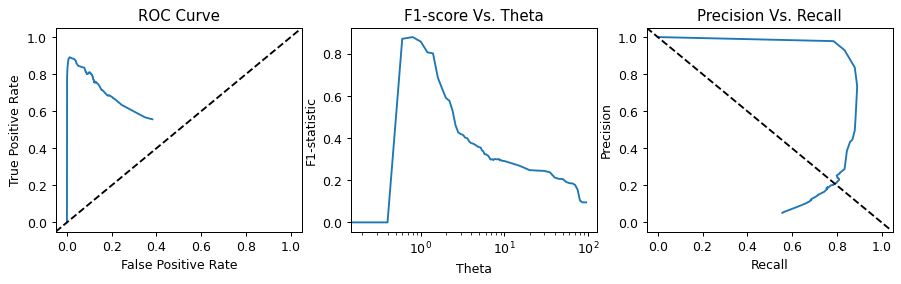

In [63]:
if perform_computation:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3), dpi=90)

    ax=axes[0]
    ax.plot(fpr_list, tpr_list)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.plot(np.arange(-0.05, 1.05, 0.01), np.arange(-0.05, 1.05, 0.01), ls='--', c='black')

    ax=axes[1]
    ax.plot(all_theta, f1_list)
    ax.set_xlabel('Theta')
    ax.set_ylabel('F1-statistic')
    ax.set_title('F1-score Vs. Theta')
    ax.set_xscale('log')

    ax=axes[2]
    ax.plot(tpr_list, ppv_list)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision Vs. Recall')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.plot(np.arange(-0.05, 1.05, 0.01), 1-np.arange(-0.05, 1.05, 0.01), ls='--', c='black')
    None

In [64]:
if perform_computation:
    best_theta = all_theta[np.argmax(f1_list)]
    print(f'Best theta w.r.t. the F-score is {best_theta}')

Best theta w.r.t. the F-score is 0.8


Now let's try the tuned hyper-parameters, and verify whether it visually improved the Boltzman machine.

In [65]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


The reference and solution images are the same to a T! Well done on this test case.


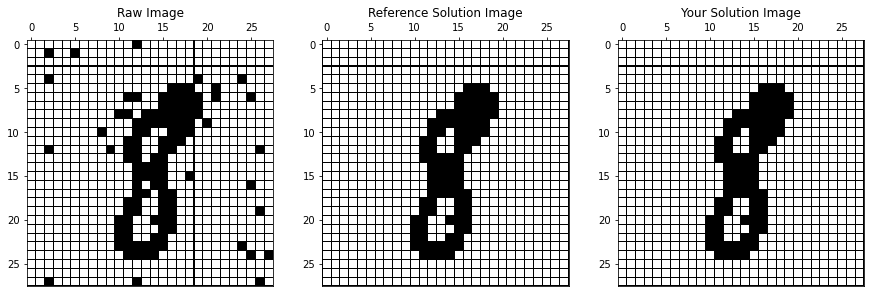

    Enter nothing to go to the next image
or
    Enter "s" when you are done to recieve the three images. 
        **Don't forget to do this before continuing to the next step.**
s


In [66]:
if perform_computation:
    def test_boltzman(x, seed = 12345, theta_X=0.5*np.log(1/noise_flip_prob-1), theta_pi=best_theta, iterations=100):        
        np_random = np.random.RandomState(seed=seed)
        initial_pi = np_random.uniform(0,1, size=x.shape)
        return boltzman_meanfield(x, initial_pi, theta_X=theta_X, 
                                  theta_pi=theta_pi, iterations=iterations) >  0.5

    (orig_image, ref_image, test_im, success_is_row_inky) = show_test_cases(test_boltzman, task_id='4_V')